# US Based Ecommerce Company Sales Performance

## Project Description

A US Based Ecommerce Sales Company wants us to create a Sales Dashboard showing information of YTD Sales and generate insights for improving business performance with below scenarios :

- Create a KPI Banner showing YTD Sales, YTD Profit, YTD Quantity sold, YTD Profit Margin
- Find Year on Year Growth for each KPI and show a YTD sparkline for each measure in the KPI to understand the monthly trend for each fact
- Find YTD Sales, YoY Sales growth for different customer category. Add a trend icon for each category
- Find YTD Sales performance by each State
- Top 5 and Bottom 5 Procucts by Sales
- YTD Sales by Region to know the best and worst performing region all over country
- YTD Sales by Shipping Type to get the best shipping type percentage

The given dataset contains information on 113 thousand sales records based on product categories, customer segments, cities, and states of customer residence, and various many others.

Dataset and insporation source : 

- [Power BI Project End to End | Data Analyst Project Portfolio](https://youtu.be/-TErGczFxUs?si=wHFXuuv26a1udGR0)
- [Ecommerce Dataset](https://drive.google.com/drive/folders/1vnI_RR3iDTLb6dH_tluCSsPqWcXPRHKR.)

This python code is only for quick data understanding, most of the work (calculation and dimension/measure creation) is done directly in Tableau. While for the SQL code i used it to answer questions as well (to sharpen my SQL skills further) and ensure that the calculations in Tableau are accurate.

# Import Initial Libraries and Settings

In [97]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
from scipy.stats import skew, kurtosis, chi2_contingency

# Settings of dataframe display
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = None

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2


# Load Dataset

#### Load in Google Colab

In [98]:
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/Latihan Sendiri (Projects)/US Based Ecommerce Company Sales Performance/ecommerce_data.csv', encoding='latin-1')

#### Load in Jupyter Notebook

In [99]:
# 2. Using os.path for better cross-platform compatibility:
df = pd.read_csv(os.path.join('..', 'Original Data', 'ecommerce_data_csv.csv'), encoding='latin-1')

There are some problem in reading the csv file. I can't seem to open it normally since it will display this error :

* UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 14101: invalid continuation byte

So i would need to change the encoding to other type and in this case i use encoding='latin-1'

The same issue also occurred during data import in PostgreSQL, so the solution is to follow the same encoding format, which is LATIN1, and adjust some import options such as removing quotes and escape characters because there are some values in the product_name column that are causing errors.

In [100]:
# #This code is optional
# #Only used for machine learning purpose and cleaning values of product_name

# characters_to_remove = ['!', '@', '#', '$', '%', '^', '"', ',', '.', '/', '(',')', '', ' ']
# df['product_name'] = df['product_name'].apply(lambda x: ''.join(char for char in x if char not in characters_to_remove) if isinstance(x, str) else x)

# EDA

In [101]:
# Retrieve 10 sample lines from the available data
df.sample(10)

,customer_id,customer_first_name,customer_last_name,category_name,product_name,customer_segment,customer_city,customer_state,customer_country,customer_region,delivery_status,order_date,order_id,ship_date,shipping_type,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order
98283,C_ID_37944,Mary,Martin,Furniture,3M Hangers With Command Adhesive,Consumer,Woonsocket,Rhode Island,United States,East,Late delivery,20-09-2021,O_ID_3098461,26-09-2021,Standard Class,4,6,19.990000,124.949997,1,17.840000
112045,C_ID_45143,Patricia,Schneider,Office Supplies,Fellowes Neat Ideas Storage Cubes,Consumer,Huntsville,Texas,United States,Central,Late delivery,18-08-2022,O_ID_3112242,23-08-2022,Second Class,2,5,17.990000,149.940002,3,-1.720000
101748,C_ID_67801,Mary,Hooks,Technology,Adtran 1202752G1,Consumer,Columbia,Missouri,United States,Central,Late delivery,11-10-2021,O_ID_3101929,18-08-2021,Standard Class,4,1,30.000000,200.000000,1,42.500000
89116,C_ID_68300,Teresa,Greene,Office Supplies,Acme Forged Steel Scissors with Black Enamel Handles,Consumer,Seattle,Washington,United States,West,Late delivery,26-07-2022,O_ID_3089275,28-07-2022,First Class,1,2,25.590000,159.960007,4,63.150002
80123,C_ID_46884,Mary,Rosenblatt,Furniture,"Howard Miller 13-3/4"" Diameter Brushed Chrome Round Wall Clock",Consumer,Los Angeles,California,United States,West,Late delivery,31-08-2022,O_ID_3080277,12-01-2022,Second Class,2,4,3.500000,50.000000,1,22.790001
73919,C_ID_31985,Mary,Smith,Office Supplies,Avery Self-Adhesive Photo Pockets for Polaroid Photos,Corporate,Amarillo,Texas,United States,Central,Advance shipping,11-08-2021,O_ID_3074070,11-10-2021,Standard Class,4,2,40.790001,239.960007,4,-145.990005
41699,C_ID_67601,Jessica,Carroll,Technology,WD My Passport Ultra 2TB Portable External Hard Drive,Consumer,New York City,New York,United States,East,Late delivery,02-10-2021,O_ID_3041774,13-05-2021,Standard Class,4,6,15.600000,119.980003,2,50.099998
94256,C_ID_44925,Mary,McAdams,Office Supplies,Ibico Laser Imprintable Binding System Covers,Corporate,Hot Springs,Arkansas,United States,South,Late delivery,09-10-2021,O_ID_3094419,18-06-2021,Standard Class,4,5,16.900000,129.990005,1,40.709999
81079,C_ID_56135,Mary,Adams,Office Supplies,"SAFCO Mobile Desk Side File, Wire Frame",Corporate,Huntsville,Texas,United States,Central,Late delivery,19-01-2022,O_ID_3081233,24-01-2022,Standard Class,4,5,1.000000,100.000000,2,48.509998
6889,C_ID_62048,Angela,Hoffman,Technology,"iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4",Corporate,Louisville,Colorado,United States,West,Advance shipping,16-09-2021,O_ID_3006919,18-09-2021,Standard Class,4,2,24.000000,239.960007,1,27.000000


In [102]:
# Checking shape of dataframe
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')

Number of rows: 113270
Number of columns 21


In [103]:
# Checking basic data information
def check_data_information(df, cols):
    """
    This function provides detailed information about each column in a dataframe, including:
    - Data type of the column
    - Number of missing (null) values
    - Percentage of missing values
    - Total number of duplicated rows in the dataframe (not column-specific)
    - Number of unique values in the column
    - A sample of up to 5 unique values from the column

    Parameters:
    df (pd.DataFrame): The dataframe you want to check.
    cols (list): List of column names to check the information from.

    Returns:
    pd.DataFrame: A dataframe with detailed information for each column.
    """
    list_item = []
    for col in cols:
        list_item.append([col,                             # The column name
                          df[col].dtype,                   # The data type of the column
                          df[col].isna().sum(),            # The count of null values in the column
                          round(100 * df[col].isna().sum() / len(df[col]), 2),  # The percentage of null values
                          df.duplicated().sum(),           # The count of duplicated rows in the entire dataframe
                          df[col].nunique(),               # The count of unique values in the column
                          df[col].unique()[:5]])           # A sample of the first 5 unique values in the column

    desc_df = pd.DataFrame(data=list_item, columns='Feature, Data Type, Null Values, Null Percentage, Duplicated Values, Unique Values, Unique Sample'.split(","))
    return desc_df

columns_to_check = df.columns
check_data_information(df, columns_to_check)

,Feature,Data Type,Null Values,Null Percentage,Duplicated Values,Unique Values,Unique Sample
0,customer_id,object,0,0.0,0,42047,"[C_ID_45866, C_ID_44932, C_ID_70880, C_ID_33157, C_ID_58303]"
1,customer_first_name,object,0,0.0,0,757,"[Mary, Alan, Raymond, Joe, Andrea]"
2,customer_last_name,object,0,0.0,0,586,"[Fuller, Edelman, Gayman, Eason, Gonzalez]"
3,category_name,object,0,0.0,0,3,"[Office Supplies, Furniture, Technology]"
4,product_name,object,0,0.0,0,1849,"[Xerox 1913, #6 3/4 Gummed Flap White Envelopes, Belkin 8 Outlet Surge Protector, GBC VeloBinder Manual Binding System, Eldon Pizzaz Desk Accessories]"
5,customer_segment,object,0,0.0,0,3,"[Corporate, Consumer, Home Office]"
6,customer_city,object,0,0.0,0,531,"[New Rochelle, Houston, Louisville, Chicago, Philadelphia]"
7,customer_state,object,0,0.0,0,49,"[New York, Texas, Kentucky, Illinois, Pennsylvania]"
8,customer_country,object,0,0.0,0,1,[United States]
9,customer_region,object,0,0.0,0,4,"[East, Central, South, West]"


Several things to note here:

- There is no missing or duplicated value in this dataset.

- Since this is probably a mart sales/orders table indicated by the `order_id` column that doesn't have duplicated values (primary key), we would need to place this column at first and also change the information related to the orders followed by the customers, since currently the ordering of these columns are kinda messy.

- The date columns in this dataset, `order_date` and `ship_date` needs to be converted to date data type.

- `customer_first_name` and customer_last_name will need to be combined into full name and then the previous separated columns needs to be droppped

- At the first glance, since this is US Based data so `customer_country` will only display 1 value that is united states, usually we will just drop that column in Python and SQL but in Tableau we need that for hierarchy of country-state-city

## Initial Feature Transformation

In [104]:
# Reordering columns to make orders information at first then followed by customers related information
cols = ['order_id', 'order_date', 'ship_date', 'shipping_type', 
        'delivery_status', 'days_for_shipment_scheduled', 'days_for_shipment_real',
        'order_item_discount', 'sales_per_order', 'order_quantity', 'profit_per_order',
        'product_name', 'category_name',
        'customer_id', 'customer_first_name', 'customer_last_name', 
        'customer_segment', 'customer_city', 'customer_state', 
        'customer_country', 'customer_region']

# Reorder the dataframe columns
df = df[cols]

In [105]:
# Convert date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y')
df['ship_date'] = pd.to_datetime(df['ship_date'], format='%d-%m-%Y')

# Combine first and last name into full name
df['customer_full_name'] = df['customer_first_name'] + ' ' + df['customer_last_name']

# Drop unnecessary columns
df = df.drop(columns=['customer_first_name', 'customer_last_name'])

In [106]:
# Move customer_full_name column to beside customer_id
cols = df.columns.to_list()

# Move customer_full_name after customer_id
customer_id_index = cols.index('customer_id')
cols.remove('customer_full_name')
cols.insert(customer_id_index + 1, 'customer_full_name')

# Reorder the dataframe
df = df[cols]

# Display the new column order
df.columns.to_list()

['order_id',
 'order_date',
 'ship_date',
 'shipping_type',
 'delivery_status',
 'days_for_shipment_scheduled',
 'days_for_shipment_real',
 'order_item_discount',
 'sales_per_order',
 'order_quantity',
 'profit_per_order',
 'product_name',
 'category_name',
 'customer_id',
 'customer_full_name',
 'customer_segment',
 'customer_city',
 'customer_state',
 'customer_country',
 'customer_region']

In [107]:
# Check transformed data
df.head()

,order_id,order_date,ship_date,shipping_type,delivery_status,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order,product_name,category_name,customer_id,customer_full_name,customer_segment,customer_city,customer_state,customer_country,customer_region
0,O_ID_3001072,2022-05-11,2022-07-11,Second Class,Shipping on time,2,2,35.0,500.0,5,223.199997,Xerox 1913,Office Supplies,C_ID_45866,Mary Fuller,Corporate,New Rochelle,New York,United States,East
1,O_ID_3009170,2022-06-20,2022-06-23,Second Class,Shipping canceled,2,3,85.0,500.0,5,199.199997,#6 3/4 Gummed Flap White Envelopes,Office Supplies,C_ID_44932,Alan Edelman,Corporate,Houston,Texas,United States,Central
2,O_ID_3047567,2022-06-25,2022-06-30,Standard Class,Late delivery,4,5,75.0,44.0,5,195.500000,Belkin 8 Outlet Surge Protector,Office Supplies,C_ID_70880,Mary Gayman,Consumer,Louisville,Kentucky,United States,South
3,O_ID_3060575,2022-06-10,2022-10-10,Second Class,Late delivery,2,4,60.0,254.0,1,220.000000,GBC VeloBinder Manual Binding System,Office Supplies,C_ID_33157,Raymond Eason,Corporate,Chicago,Illinois,United States,Central
4,O_ID_3064311,2022-05-02,2022-01-08,First Class,Late delivery,1,2,125.0,500.0,1,97.500000,Eldon Pizzaz Desk Accessories,Furniture,C_ID_58303,Mary Gonzalez,Home Office,Philadelphia,Pennsylvania,United States,East


- Checking the data again, I just realized something - there are some invalid data where the ship_date is earlier than the order_date (row 5 above) which is not logically possible. This is a clear data integrity issue that could arise from:

    - Data entry errors
    - System clock/timezone issues during data recording
    - Batch processing errors
    - ETL pipeline issues
    - Database migration problems

- Since in this mart dataset there is no way for us to track down the underlying issues, we would need to filter out these rows. 

In [108]:
# Filter out the data where ship_date is earlier than order_Date
valid_date_condition = df['ship_date'] > df['order_date']

df_invalid = df[~valid_date_condition]
df = df[valid_date_condition]

# Check amount of filtered data
print(f"Amount of invalid data: {df_invalid.shape[0]}")
print(f"Amount of valid data: {df.shape[0]}")

Amount of invalid data: 24047
Amount of valid data: 89223


In [109]:
# Grouping columns based on the data type
nums_cols = df.select_dtypes(include=['number', 'int32', 'int64', 'float32', 'float64']).columns.to_list()
cats_cols = df.select_dtypes(include=['object', 'category', 'string']).columns.to_list()
date_cols = df.select_dtypes(include=['datetime', 'datetime64', 'datetime64[ns]', 'timedelta']).columns.to_list()

## Statistical Analysis

### Numerical columns

In [110]:
# Describe numerical columns
def describe_numerical_combined(data, col_series, target_col=None):
    """
    Generate descriptive statistics for numerical columns in a dataframe,
    both overall and optionally grouped by target variable.
    
    Parameters:
    data (pd.DataFrame): The dataframe containing the numerical columns
    col_series (list): The list of numerical columns to describe
    target_col (str, optional): The name of the target column for classification
    
    Returns:
    pd.DataFrame: A dataframe containing descriptive statistics, with target classes if specified
    """
    # Overall statistics (original approach)
    overall_summary = data[col_series].describe().transpose().reset_index()
    overall_summary = overall_summary.rename(columns={'index': 'Feature'})
    
    # Add additional statistics for overall data
    overall_summary['range'] = overall_summary['max'] - overall_summary['min']
    overall_summary['IQR'] = overall_summary['75%'] - overall_summary['25%']
    overall_summary['CV'] = (overall_summary['std'] / overall_summary['mean']) * 100
    
    # Calculate skewness and kurtosis for numerical columns
    numerical_data = data[col_series].select_dtypes(include=['int64', 'float64']).dropna()
    overall_summary['skewness'] = [skew(numerical_data[col]) for col in numerical_data.columns]
    overall_summary['kurtosis'] = [kurtosis(numerical_data[col]) for col in numerical_data.columns]
    
    # Rename columns to indicate these are overall statistics
    overall_summary.columns = ['Feature'] + [f'overall_{col}' if col != 'Feature' else col 
                                           for col in overall_summary.columns[1:]]
    
    final_summary = overall_summary
    
    # If target column is provided, add class-specific statistics
    if target_col is not None:
        target_classes = sorted(data[target_col].unique())
        class_summaries = []
        
        for target_class in target_classes:
            # Filter data for current class
            class_data = data[data[target_col] == target_class]
            
            # Calculate basic statistics
            class_summary = class_data[col_series].describe().transpose().reset_index()
            class_summary = class_summary.rename(columns={'index': 'Feature'})
            
            # Add additional statistics
            class_summary['range'] = class_summary['max'] - class_summary['min']
            class_summary['IQR'] = class_summary['75%'] - class_summary['25%']
            class_summary['CV'] = (class_summary['std'] / class_summary['mean']) * 100
            
            # Calculate skewness and kurtosis
            numerical_class_data = class_data[col_series].select_dtypes(include=['int64', 'float64']).dropna()
            class_summary['skewness'] = [skew(numerical_class_data[col]) for col in numerical_class_data.columns]
            class_summary['kurtosis'] = [kurtosis(numerical_class_data[col]) for col in numerical_class_data.columns]
            
            # Rename columns to indicate which class they belong to
            class_summary.columns = ['Feature'] + [f'class_{target_class}_{col}' if col != 'Feature' else col 
                                                 for col in class_summary.columns[1:]]
            
            class_summaries.append(class_summary)
        
        # Combine all class summaries
        all_class_summaries = class_summaries[0]
        for summary in class_summaries[1:]:
            all_class_summaries = pd.merge(all_class_summaries, summary, on='Feature')
            
        # Merge with overall summary
        final_summary = pd.merge(final_summary, all_class_summaries, on='Feature')
        
        # Reorder columns to group statistics by type rather than by class
        # Get all column names except 'Feature'
        cols = final_summary.columns.tolist()
        cols.remove('Feature')
        
        # Group similar statistics together
        stats = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'IQR', 'CV', 'skewness', 'kurtosis']
        new_cols = ['Feature']
        
        for stat in stats:
            stat_cols = [col for col in cols if stat in col]
            new_cols.extend(stat_cols)
            
        final_summary = final_summary[new_cols]
    
    return final_summary

In [111]:
describe_numerical_combined(df, nums_cols, target_col=None)

,Feature,overall_count,overall_mean,overall_std,overall_min,overall_25%,overall_50%,overall_75%,overall_max,overall_range,overall_IQR,overall_CV,overall_skewness,overall_kurtosis
0,days_for_shipment_scheduled,89223.0,2.954720,1.333477,0.00,2.000000,4.000000,4.000000,4.00000,4.00000,2.000000,45.130398,-0.683424,-1.144162
1,days_for_shipment_real,89223.0,3.436692,1.527472,1.00,2.000000,3.000000,5.000000,6.00000,5.00000,3.000000,44.445992,0.364339,-1.175966
2,order_item_discount,89223.0,20.934215,22.045507,0.00,5.500000,14.400000,30.000000,375.00000,375.00000,24.500000,105.308496,2.922478,22.626462
3,sales_per_order,89223.0,203.048079,134.314869,9.99,119.980003,199.899994,299.950012,1999.98999,1989.99999,179.970009,66.149293,2.974712,23.970236
4,order_quantity,89223.0,1.932035,1.334581,1.00,1.000000,1.000000,3.000000,5.00000,4.00000,2.000000,69.076420,1.176202,-0.008291
5,profit_per_order,89223.0,23.087691,103.305209,-3366.00,7.100000,32.000000,65.570000,2600.00000,5966.00000,58.470000,447.447126,-3.417645,45.378967


### Categorical columns

In [112]:
# Describe categorical columns
def describe_categorical_combined(data, col_series, target_col=None):
    """
    Generate descriptive statistics for categorical columns in a dataframe,
    both overall and optionally grouped by target variable.
    
    Parameters:
    data (pd.DataFrame): The dataframe containing the categorical columns
    col_series (list): The list of categorical columns to describe
    target_col (str, optional): The name of the target column for classification
    
    Returns:
    pd.DataFrame: A dataframe containing descriptive statistics, with target classes if specified
    """
    # Overall statistics
    cats_summary = data[col_series].describe().transpose().reset_index().rename(columns={'index': 'Feature'})
    
    # Add additional statistics for overall data
    cats_summary['bottom'] = [data[col].value_counts().idxmin() for col in col_series]
    cats_summary['freq_bottom'] = [data[col].value_counts().min() for col in col_series]
    cats_summary['top_percentage'] = [round(data[col].value_counts().max() / len(data) * 100, 2) 
                                    for col in col_series]
    cats_summary['bottom_percentage'] = [round(data[col].value_counts().min() / len(data) * 100, 2) 
                                       for col in col_series]
    
    # Rename columns to indicate these are overall statistics
    cats_summary.columns = ['Feature'] + [f'overall_{col}' if col != 'Feature' else col 
                                        for col in cats_summary.columns[1:]]
    
    final_summary = cats_summary
    
    # If target column is provided, add class-specific statistics
    if target_col is not None:
        target_classes = sorted(data[target_col].unique())
        class_summaries = []
        
        for target_class in target_classes:
            # Filter data for current class
            class_data = data[data[target_col] == target_class]
            
            # Calculate basic statistics
            class_summary = class_data[col_series].describe().transpose().reset_index()
            class_summary = class_summary.rename(columns={'index': 'Feature'})
            
            # Add additional statistics
            class_summary['bottom'] = [class_data[col].value_counts().idxmin() for col in col_series]
            class_summary['freq_bottom'] = [class_data[col].value_counts().min() for col in col_series]
            class_summary['top_percentage'] = [round(class_data[col].value_counts().max() / len(class_data) * 100, 2) 
                                             for col in col_series]
            class_summary['bottom_percentage'] = [round(class_data[col].value_counts().min() / len(class_data) * 100, 2) 
                                                for col in col_series]
            
            # Rename columns to indicate which class they belong to
            class_summary.columns = ['Feature'] + [f'class_{target_class}_{col}' if col != 'Feature' else col 
                                                 for col in class_summary.columns[1:]]
            
            class_summaries.append(class_summary)
        
        # Combine all class summaries
        all_class_summaries = class_summaries[0]
        for summary in class_summaries[1:]:
            all_class_summaries = pd.merge(all_class_summaries, summary, on='Feature')
            
        # Merge with overall summary
        final_summary = pd.merge(final_summary, all_class_summaries, on='Feature')
        
        # Reorder columns to group statistics by type rather than by class
        cols = final_summary.columns.tolist()
        cols.remove('Feature')
        
        # Group similar statistics together
        stats = ['count', 'unique', 'top', 'freq', 'bottom', 'freq_bottom', 
                'top_percentage', 'bottom_percentage']
        new_cols = ['Feature']
        
        for stat in stats:
            stat_cols = [col for col in cols if stat in col]
            new_cols.extend(stat_cols)
            
        final_summary = final_summary[new_cols]
    
    return final_summary

In [113]:
describe_categorical_combined(df, cats_cols)

,Feature,overall_count,overall_unique,overall_top,overall_freq,overall_bottom,overall_freq_bottom,overall_top_percentage,overall_bottom_percentage
0,order_id,89223,89223,O_ID_3001072,1,O_ID_3001072,1,0.00,0.00
1,shipping_type,89223,4,Standard Class,53240,Same Day,2860,59.67,3.21
2,delivery_status,89223,4,Late delivery,49321,Shipping canceled,3927,55.28,4.40
3,product_name,89223,1849,Staples,447,Ultra Commercial Grade Dual Valve Door Closer,4,0.50,0.00
4,category_name,89223,3,Office Supplies,53729,Technology,16264,60.22,18.23
5,customer_id,89223,38593,C_ID_52685,5,C_ID_70273,1,0.01,0.00
6,customer_full_name,89223,39558,Mary Miller,387,Pamela Overfelt,1,0.43,0.00
7,customer_segment,89223,3,Consumer,46229,Home Office,15931,51.81,17.86
8,customer_city,89223,531,New York City,8163,Linden,6,9.15,0.01
9,customer_state,89223,49,California,17898,Wyoming,10,20.06,0.01


### Date columns

In [114]:
# Function to analyze date columns
from datetime import datetime

def analyze_date_columns(df, date_columns):
    """
    Comprehensive analysis of date columns including various temporal features
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing date columns
    date_columns (list): List of column names containing dates
    
    Returns:
    pandas.DataFrame: dates_summary statistics and temporal features for each date column
    """
    dates_summary = df[date_columns].describe().transpose()
    
    # Basic range calculations
    dates_summary['date_range_days'] = dates_summary['max'] - dates_summary['min']
    dates_summary['date_range_months'] = dates_summary['date_range_days'].apply(lambda x: x.days / 30)
    dates_summary['date_range_years'] = dates_summary['date_range_days'].apply(lambda x: x.days / 365)
    
    # Additional temporal features
    for col in date_columns:
        # Distribution across time periods
        dates = df[col].dropna()
        dates_summary.loc[col, 'unique_years'] = dates.dt.year.nunique()
        dates_summary.loc[col, 'unique_months'] = dates.dt.to_period('M').nunique()
        dates_summary.loc[col, 'unique_days'] = dates.dt.date.nunique()
        
        # Temporal patterns
        dates_summary.loc[col, 'weekend_percentage'] = (dates.dt.dayofweek.isin([5, 6]).mean()) * 100
        dates_summary.loc[col, 'business_hours_percentage'] = (
            dates[dates.dt.hour.between(9, 17)].count() / dates.count()
        ) * 100 if hasattr(dates.dt, 'hour') else np.nan
        
        # Seasonality indicators
        dates_summary.loc[col, 'most_common_month'] = dates.dt.month.mode().iloc[0]
        dates_summary.loc[col, 'most_common_weekday'] = dates.dt.day_name().mode().iloc[0]
        
        # Gaps analysis
        sorted_dates = dates.sort_values()
        gaps = sorted_dates.diff().dropna()
        dates_summary.loc[col, 'max_gap_days'] = gaps.dt.days.max()
        dates_summary.loc[col, 'median_gap_days'] = gaps.dt.days.median()
        
        # Future/Past analysis
        now = datetime.now()
        dates_summary.loc[col, 'future_dates_percentage'] = (dates > now).mean() * 100
        
        # Regularity check
        dates_summary.loc[col, 'is_regular_interval'] = gaps.dt.days.std() < 1
    
    return dates_summary

In [115]:
analyze_date_columns(df, date_cols)

,count,mean,min,25%,50%,75%,max,date_range_days,date_range_months,date_range_years,unique_years,unique_months,unique_days,weekend_percentage,business_hours_percentage,most_common_month,most_common_weekday,max_gap_days,median_gap_days,future_dates_percentage,is_regular_interval
order_date,89223,2021-11-23 18:36:29.220268288,2021-01-04 00:00:00,2021-05-29 00:00:00,2021-11-25 00:00:00,2022-05-09 00:00:00,2022-12-31 00:00:00,726 days 00:00:00,24.200000,1.989041,2.0,24.0,679.0,28.660771,0.0,3.0,Monday,14.0,0.0,0.0,True
ship_date,89223,2022-01-01 13:01:33.809892096,2021-01-17 00:00:00,2021-07-21 00:00:00,2021-12-13 00:00:00,2022-06-26 00:00:00,2023-03-04 00:00:00,776 days 00:00:00,25.866667,2.126027,3.0,27.0,690.0,27.844838,0.0,9.0,Tuesday,31.0,0.0,0.0,True


There are several interesting things and pieces of information that we can gather even only up until here, some of them are :

1. There are transactions that have minus profit, probably due to high shipping cost or other expenses.

2. The max order_date is 31-12-2022	but the max ship_date is 04-03-2023, probably happened in products with low or minus profits due to delay in shipping the goods to the customer. (could be useful depends on the business problems/context that we want to solve).

In [116]:
# Quick check on the distribution of some values
nums_to_visualize = ['sales_per_order','profit_per_order', 'order_quantity']
cats_to_visualize = ['category_name', 'customer_region', 'shipping_type', 'customer_segment']

geo_to_count = ['customer_state', 'customer_city']

In [117]:
# Categorical Counts
for col in cats_to_visualize :
  print(f'Value counts untuk {col} :')
  print(df[col].value_counts(), '\n')

Value counts untuk category_name :
category_name
Office Supplies    53729
Furniture          19230
Technology         16264
Name: count, dtype: int64 

Value counts untuk customer_region :
customer_region
West       28601
East       25455
Central    20694
South      14473
Name: count, dtype: int64 

Value counts untuk shipping_type :
shipping_type
Standard Class    53240
Second Class      17546
First Class       15577
Same Day           2860
Name: count, dtype: int64 

Value counts untuk customer_segment :
customer_segment
Consumer       46229
Corporate      27063
Home Office    15931
Name: count, dtype: int64 



In [118]:
# City and State count
for col in geo_to_count :
  print(f'Value counts untuk {col} :')
  print(df[col].value_counts(), '\n')

Value counts untuk customer_state :
customer_state
California              17898
New York                10065
Texas                    8827
Pennsylvania             5263
Washington               4536
Illinois                 4360
Ohio                     4208
Florida                  3394
Michigan                 2274
North Carolina           2204
Virginia                 2046
Arizona                  2017
Georgia                  1632
Tennessee                1630
Colorado                 1559
Indiana                  1334
Kentucky                 1253
Massachusetts            1211
Oregon                   1137
New Jersey               1133
Wisconsin                 955
Maryland                  943
Delaware                  821
Minnesota                 793
Connecticut               736
Missouri                  572
Oklahoma                  569
Alabama                   558
Arkansas                  536
Rhode Island              525
Utah                      474
Mississippi        

In [119]:
# Product count
df['product_name'].value_counts()

product_name
Staples                                          447
Staple envelope                                  432
Easy-staple paper                                399
KI Adjustable-Height Table                       181
Avery Non-Stick Binders                          172
                                                ... 
PNY Rapid USB Car Charger - Black                  6
Xerox 1984                                         6
Cubify CubeX 3D Printer Triple Head Print          6
RCA ViSYS 25425RE1 Corded phone                    6
Ultra Commercial Grade Dual Valve Door Closer      4
Name: count, Length: 1849, dtype: int64

All of the values format are consistent and requires no further preprocessing.

## Quick Univariate Analysis For Numerical and Categorical Columns

In [120]:
print(len(nums_cols))
print(len(cats_cols))

6
12


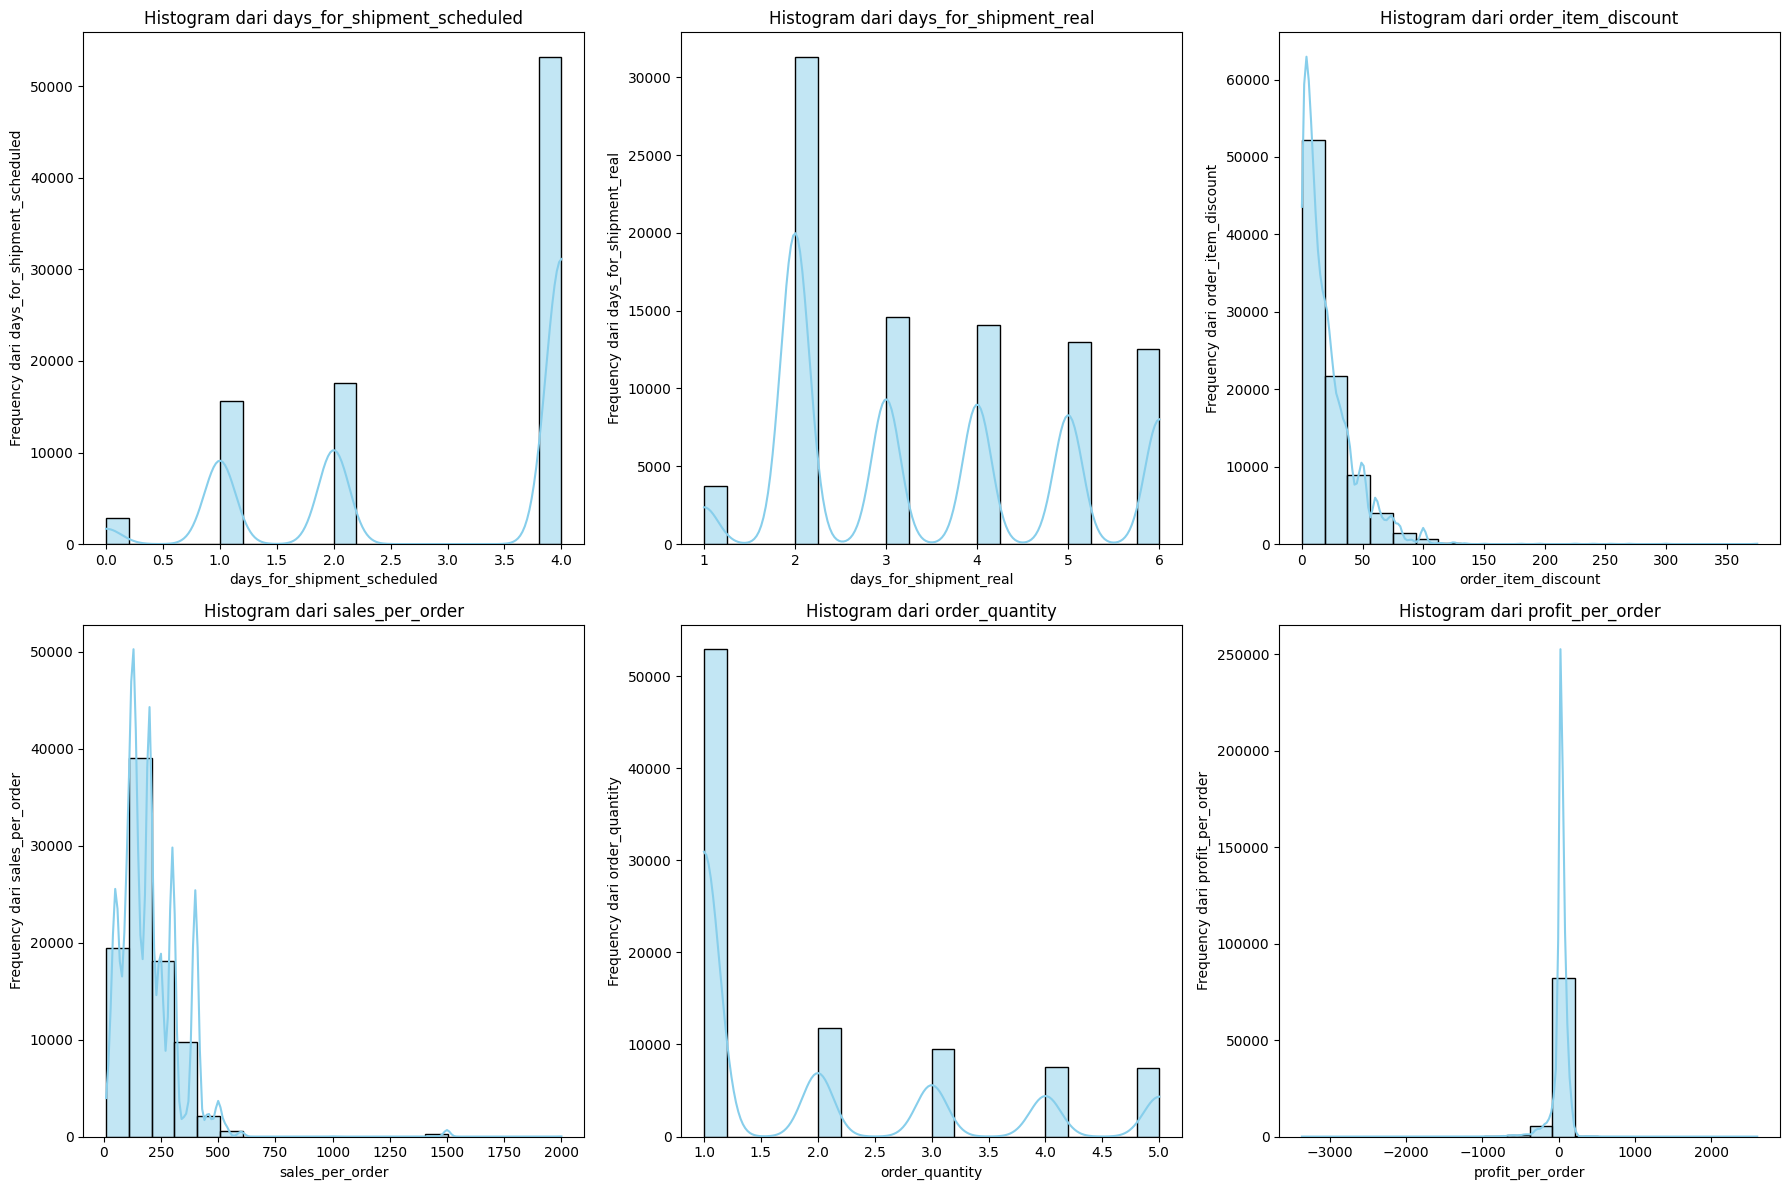

In [121]:
# Histogram
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
ax = ax.flatten()

for i in range(len(nums_cols)):
  sns.histplot(ax=ax[i], x=df[nums_cols[i]], bins=20, color='skyblue', edgecolor='black', kde=True)
  ax[i].set_title(f'Histogram dari {nums_cols[i]}')
  ax[i].set_ylabel(f'Frequency dari {nums_cols[i]}')
  ax[i].set_xlabel(f'{nums_cols[i]}')

plt.tight_layout()

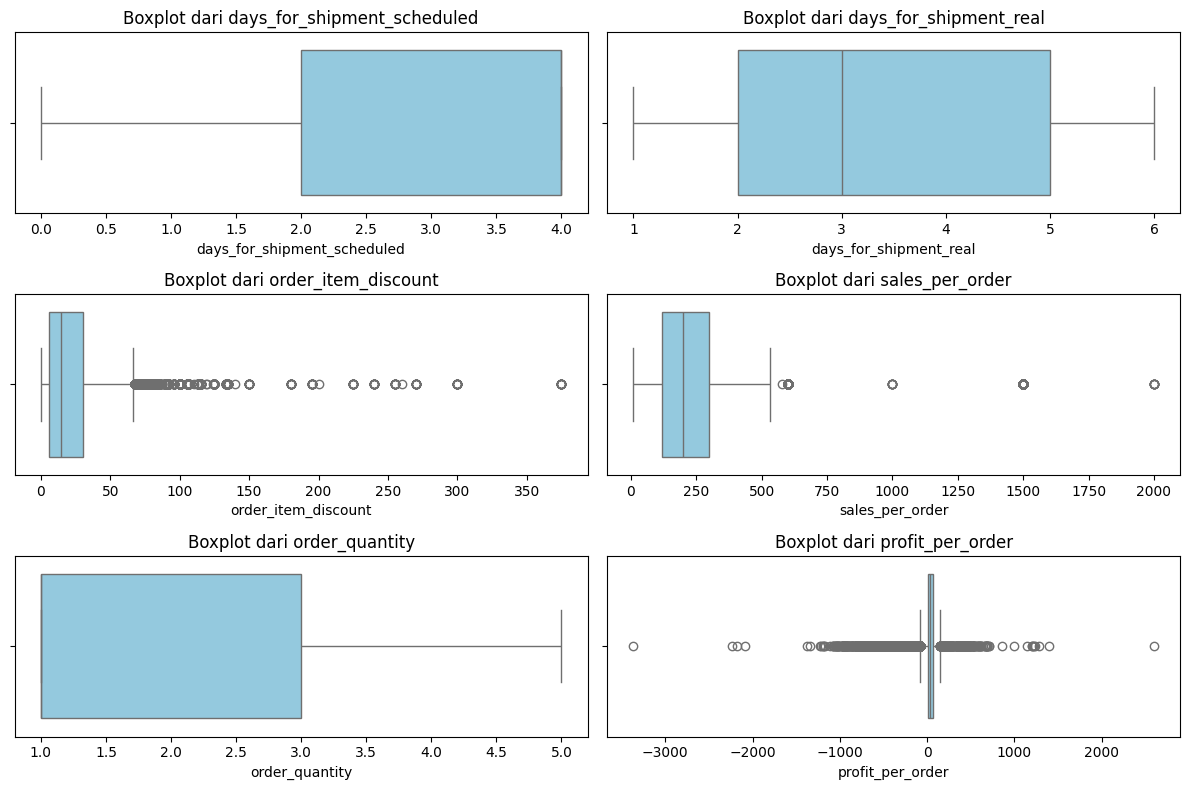

In [122]:
# Boxplot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
ax = ax.flatten()

for i in range(len(nums_cols)) :
  sns.boxplot(ax=ax[i], x=df[nums_cols[i]], orient='h', color='skyblue')
  ax[i].set_title(f'Boxplot dari {nums_cols[i]}')

plt.tight_layout()

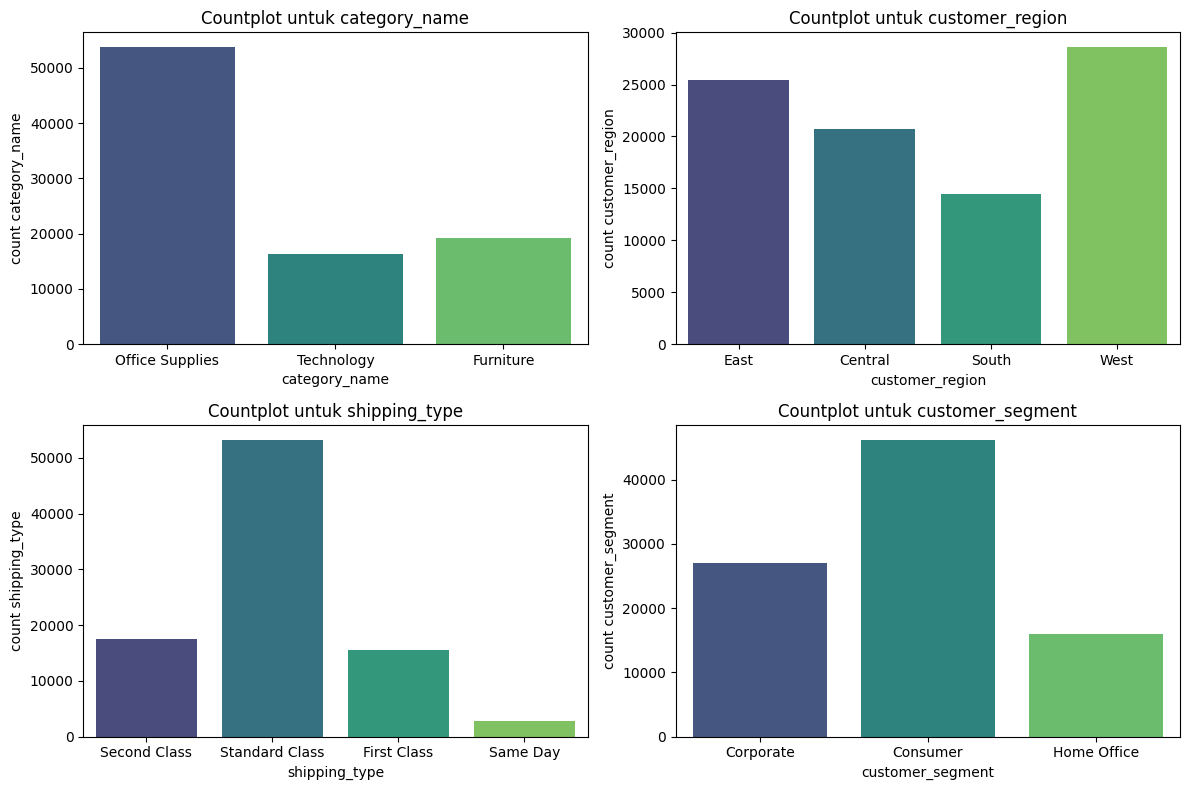

In [123]:
# Countplot Categorical
cats_cols_temp = ['category_name', 'customer_region', 'shipping_type', 'customer_segment']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax = ax.flatten()

for i in range(len(cats_cols_temp)):
    sns.countplot(data=df, x=cats_cols_temp[i], palette='viridis', ax=ax[i])
    ax[i].set_title(f'Countplot untuk {cats_cols_temp[i]}')
    ax[i].set_ylabel(f'count {cats_cols_temp[i]}')
    ax[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

In [124]:
# Last check before exporting dataset
df.head()

,order_id,order_date,ship_date,shipping_type,delivery_status,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order,product_name,category_name,customer_id,customer_full_name,customer_segment,customer_city,customer_state,customer_country,customer_region
0,O_ID_3001072,2022-05-11,2022-07-11,Second Class,Shipping on time,2,2,35.0,500.0,5,223.199997,Xerox 1913,Office Supplies,C_ID_45866,Mary Fuller,Corporate,New Rochelle,New York,United States,East
1,O_ID_3009170,2022-06-20,2022-06-23,Second Class,Shipping canceled,2,3,85.0,500.0,5,199.199997,#6 3/4 Gummed Flap White Envelopes,Office Supplies,C_ID_44932,Alan Edelman,Corporate,Houston,Texas,United States,Central
2,O_ID_3047567,2022-06-25,2022-06-30,Standard Class,Late delivery,4,5,75.0,44.0,5,195.500000,Belkin 8 Outlet Surge Protector,Office Supplies,C_ID_70880,Mary Gayman,Consumer,Louisville,Kentucky,United States,South
3,O_ID_3060575,2022-06-10,2022-10-10,Second Class,Late delivery,2,4,60.0,254.0,1,220.000000,GBC VeloBinder Manual Binding System,Office Supplies,C_ID_33157,Raymond Eason,Corporate,Chicago,Illinois,United States,Central
5,O_ID_3074984,2022-06-24,2022-06-28,Standard Class,Shipping on time,4,4,80.0,500.0,2,-349.859985,Hoover Shoulder Vac Commercial Portable Vacuum,Office Supplies,C_ID_34556,Joe Leatherbury,Home Office,Columbia,South Carolina,United States,South


# Export dataset for tableau dashboard creation

In [125]:
# Export the final dataframe
df.to_csv('ecommerce_data_cleaned.csv', index=False)

We have latitude and longitude of each state and city in a separate csv file that we will join with this dataframe in Tableau.